an NN is a mathematical expression that
1. takes input as data & weights/biases as parameters
2. followed by a loss function that measures accuracy of predictions (loss approaches $0$ as predictions approach targets/NN behaves well on training set)
3. followed by backpropagation to backward the loss. backpropagation gets the gradient & tells us how to tune the parameters to decrease loss locally
4. iterate $2-3$ many times (gradient descent) to approach loss minima

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import math
import torch

In [56]:
class Value:

  def __init__(self, data, _children=(), _op=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op

  def __repr__(self):
    return f'Value(data={self.data})'

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    def _backward():
      self.grad += 1.0 * out.grad # dL/dx chain rule (1.0 = local gradient)
      other.grad += 1.0 * out.grad # dL/dy chain rule
    out._backward = _backward
    return out

  def __radd__(self, other):
    return self + other

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self +  (-other)

  def __pow__(self, other):
    out = Value(self.data ** other, (self,), f'**{other}')
    def _backward():
      self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward
    return out

  def exp(self): # e^x
    x = self.data
    out = Value(math.exp(x), (self,), 'exp')
    def _backward():
      self.grad += out.data * out.grad # d(e^x) / dx = e^x
    self._backward = _backward
    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out = Value(t, (self,), 'tanh')
    out._backward = _backward
    return out

  def backward(self):
    def topsort(node):
      stk, _visited = [node], set()
      out = []

      while stk:
        n = stk.pop()
        if n not in _visited:
          _visited.add(n)
          for child in n._prev:
            stk.append(child)
          out = [n] + out
      return out

    self.grad = 1.0
    s = topsort(self)
    for node in reversed(s):
      node._backward()

$tanh(x) = \frac{e^{2x}-1}{e^{2x}+1}$

$\frac{d}{dx}tanh(x) = 1 - tanh^2(x)$

$xw + b$

In [17]:
# inputs
x1 = Value(2.0)
x2 = Value(0.0)

# weights
w1 = Value(-3.0)
w2 = Value(1.0)

# bias
b = Value(6.88137)

# x1w1 + x2*w2 + b
x1w1 = x1 * w1
x2w2 = x2 * w2
xw = x1w1 + x2w2
n1 = xw + b
n2 = n1.tanh()

n2.backward()
n1.grad

0.5000025364090595

In [29]:
x = Value(1.0)
z = x + x
z.backward()
x.grad

2.0

In [33]:
q, visited = [], set()
n2._prev = [n1]
n1._prev = [xw, b]
xw._prev = [x1w1, x2w2]

def build_topo(node):
  if node not in visited:
    visited.add(node)
    for child in node._prev:
      build_topo(child)
    q.append(node)

build_topo(n2)
q

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.88137),
 Value(data=0.8813700000000004),
 Value(data=0.7071049876722272)]

In [34]:
def topsort(node):
  stk, _visited = [node], set()
  out = []

  while stk:
    n = stk.pop()
    if n not in _visited:
      _visited.add(n)
      for child in n._prev:
        stk.append(child)
      out = [n] + out
  return out

topsort(n2)

[Value(data=-3.0),
 Value(data=2.0),
 Value(data=-6.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.88137),
 Value(data=0.8813700000000004),
 Value(data=0.7071049876722272)]

In [20]:
n2._backward()
n1.grad

0.5000025364090595

In [21]:
n1._backward()
xw.grad

0.5000025364090595

In [4]:
1 - n2.data**2

0.5000025364090595

$ \frac{d (xw + b)}{d x_2} = \frac{d (xw+b)}{d (x_2w_2)} \frac{d (x_2w_2)}{d x_2} = w_2 \times x_2w_2\text{.grad}$

In [5]:
x1w1.grad = 0.5
x2w2.grad = 0.5
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
xw.grad = 0.5
b.grad = 0.5

In [6]:
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
e = a * b
d = e + c
L1 = d * Value(-2.0)

In [7]:
h = 0.001
a = Value(2.0)
b = Value(-3.0)
c = Value(10.0)
e = a * b
d = e + c
f = Value(-2.0)
L2 = d * f + Value(h)

In [8]:
(L2.data - L1.data) / h

1.000000000000334

$a = 2$

$b = -3$

$c=10$

$e=ab$

$d = e + c$

$f = -2$

$ L = df $

$\frac{dL}{de} = \frac{dL}{dd}\frac{dd}{de} = f\frac{dd}{de} = f = -2$

$\frac{dL}{da} = \frac{dL}{de}\frac{de}{da} = fb$

In [9]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f
L

Value(data=-8.0)

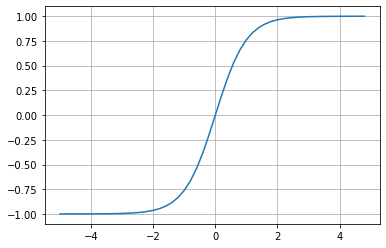

In [10]:
r = np.arange(-5,5,0.2)
plt.plot(r, np.tanh(r)); plt.grid()

In [48]:
x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.88137]).double() ; b.requires_grad = True

In [50]:
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

0.7071050214706146


neuron from micrograd

In [131]:
import random

class Neuron:

  # nin: # weights (dimension of input)
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1, 1))

  def  __call__(self, x):
    # eval wx + b
    activation = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
    out = activation.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

n = Neuron(2)
n([2.0, 3.0])

Value(data=0.9034814061141629)

how come grads evaluate correctly despite never specifying `_prev` / `_children`?

In [132]:
class Layer:

  # nin:
  # nout:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    if len(outs) == 1:
      return outs[0]
    return outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    size = [nin] + nouts
    self.layers = [Layer(size[i], size[i + 1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [250]:
# Layer(2, 3)([2.0, 3.0, -1.0])
n = MLP(3, [4, 4, 1 ])
n([2.0, 3.0, -1.0])

Value(data=-0.8474545007247285)

In [251]:
len(n.parameters())

41

MSE loss

In [252]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [362]:
N = 20
STEP_SIZE = 0.05

for k in range(N):
  # forward pass
  # loss measures how well the NN is performing
  # y_gt: y ground truth
  ypred = [n(x) for x in xs]
  loss = sum((y_out - y_gt) ** 2 for y_gt, y_out in zip(ys, ypred))

  # zero grad
  for p in n.parameters():
    p.grad = 0.0

  # backward pass
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -STEP_SIZE * p.grad # -= to minimize loss; gradient is vector in direction of increasing loss
  print(k, loss.data)

0 4.6939196012913255e-27
1 4.6939196012913255e-27
2 4.6939196012913255e-27
3 4.6939196012913255e-27
4 4.6939196012913255e-27
5 4.6939196012913255e-27
6 4.6939196012913255e-27
7 4.6939196012913255e-27
8 4.6939196012913255e-27
9 4.6939196012913255e-27
10 4.6939196012913255e-27
11 4.6939196012913255e-27
12 4.6939196012913255e-27
13 4.6939196012913255e-27
14 4.6939196012913255e-27
15 4.6939196012913255e-27
16 4.6939196012913255e-27
17 4.6939196012913255e-27
18 4.6939196012913255e-27
19 4.6939196012913255e-27


In [363]:
ypred

[Value(data=0.9999999999999338),
 Value(data=-1.0),
 Value(data=-1.0),
 Value(data=0.9999999999999822)]